In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
from scipy import integrate   # constants
import xarray
#autos = constants.physical_constants['atomic unit of time'][0] # seconds per a.u. of time
#c = 137  ##(au)
au_to_nm = 0.0529177249
au_to_micm = au_to_nm*1e-3
au_to_m = 0.0529177249e-9
au_to_voltpernm = 5.14220826e2  #1 au = 5.14220652E+11 V/m
c_light =  137.03599 #a.u.

#hbar_to_js =  6.62607015e-34  #converts hbar to joule*sec
hbar_to_eV_fs = 0.658211957  #eV to fs  #6.58211957 × 10-16 electron volts second

root_oct = './Maxwell/'
#source_oct = './Source/'
source_oct ='/ada/ptmp/mpsd/albari/everything_everywhere_allatonce/'+ \
    'the_reference_run/the_the_reference_run/emptyrun200_kbox/offset_propertime_ncdftocompare/Maxwell/'
structure_name = 'archimedean_spiral'
# with open('inp') as input_file:
#     for line in input_file:
#         if line.split('=')[0] == "MaxwellOutputInterval":
#             output_interval = int(line.split(" = ")[1])

tdDirs = os.listdir(source_oct+'output_iter')  #this is based on empty directory, which has less outputint
tdDirs.sort()

try:
    output_interval = int(tdDirs[1][-7:])
except ValueError:
    output_interval = 1
    
nframes = int(len(tdDirs))
timeitersfull = list(range(0, output_interval*nframes, output_interval))

# read a field from axis to set plotting params and time array to consider
filename = 'orbital_angular_momentum-z.x=0,y=0'
#timeiters = timeitersfull[:-1]  # if the run is cut short, this will prevent abrupt stopping of the code due to\
timeiters = [0, 6000,8000,11000]  #timeitersfull[15:18]
# incomplete output_iter folder
nframes = len(timeiters)
# read the points size beforehand
# propagation axis parameters
oam_field_oct = np.genfromtxt(root_oct+"output_iter/td.0000000/"+filename)
npoints = oam_field_oct[:, 0]
z_nm = npoints*au_to_micm
oamfield = np.zeros((nframes,len(npoints)))
   
# plane plotting parameters, if needed
filename2 = 'orbital_angular_momentum-z.z=0'
oamdata = np.genfromtxt(root_oct+"output_iter/td.0000000/"+filename2)
npoints2 = int(np.sqrt(oamdata[:, 2].shape[0]))
xarr = np.reshape(oamdata[:, 0], (npoints2, npoints2))
yarr = np.reshape(oamdata[:, 1], (npoints2, npoints2))
xs = xarr[:, 0]
ys = yarr[0, :]
# parse dt
with open('exec/parser.log', 'r') as ff:
    lines = ff.readlines()
    for line in lines:
        if 'TDTimeStep' in line:
            timestep = float(line.split()[-1])

def field_full_reader(field_name, time_list, folder_oct = root_oct):
    labs = ['x','y','z']
    filename_field_list = [None]*3
    field_complete = np.zeros((len(time_list), 3, npoints2, npoints2, len(npoints)))  # 3 dimensions
    for its,ts in enumerate(time_list):
        filepath = folder_oct+'output_iter/td.{}/'.format(str(ts).zfill(7))
        for ax in  [0,1,2]:             # np.arange(0,3):
            filename_field_list[ax] = [field_name +'-'+ labs[ax]+'.ncdf']
            field_read = xarray.open_dataset(filepath+str(filename_field_list[ax][0]),engine='netcdf4')
            print('reading'+filepath+str(filename_field_list[ax][0]))
            field_selected = field_read.rdata
            field_complete[its, ax,:, :, :] = field_selected
    return field_complete

def integrate_over_zslice(field_array, xx, yy):  # receives a field and integrates over given values
    to_integrate = np.abs(field_array) # there was a aquare here, dunno why
    dx = (xx[1]-xx[0])    #*au_to_micm
    dy = (yy[1]-yy[0])    #*au_to_micm
    int_overy = integrate.simps(to_integrate,dx = dx, axis =-1) #changed from simpson for whatever reason I guess
    total_int = integrate.simps(np.abs(int_overy),dx = dy, axis =-1)
    #avg_overplane = total_int/((xx.max()-xx.min())*(yy.max()-yy.min())) # let us not average
    return float(total_int)

def field_reader(field_name, time_list, x_chosen_index, y_chosen_index, folder_oct = root_oct):
    labs = ['x','y','z']
    filename_field_list = [None]*3
    field_3D_along_axis = np.zeros((len(time_list), 3, len(npoints)))  # 3 dimensions
    for its,ts in enumerate(time_list):
        filepath = folder_oct+'output_iter/td.{}/'.format(str(ts).zfill(7))
        for ax in  [0,1,2]:             # np.arange(0,3):
            filename_field_list[ax] = [field_name +'-'+ labs[ax]+'.ncdf']
            field_read = xarray.open_dataset(filepath+str(filename_field_list[ax][0]),engine='netcdf4')
            print('reading'+filepath+str(filename_field_list[ax][0]))
            field_selected_axis = field_read.rdata[x_chosen_index,y_chosen_index,:]
            field_3D_along_axis[its, ax,:] = field_selected_axis
    return field_3D_along_axis

coef = 4054.0
xp = 17*coef  #19*coef
yp = 17*coef  #19*coef
x_chosen_index = np.argmin(abs(xs-xp))
y_chosen_index = np.argmin(abs(ys-yp))
efield_tot = np.zeros((len(timeiters),3,len(z_nm))) # keeps x, y and z components just in case
efield_source = np.zeros((len(timeiters),3,len(z_nm)))
efield_x = np.zeros((len(timeiters),len(z_nm)))
efield_x_source = np.zeros((len(timeiters),len(z_nm)))

for its, ts in enumerate(timeiters):
    efield_tot[its,:,:] = field_reader('e_field',[ts], x_chosen_index, y_chosen_index)
    efield_source[its,:,:] = 5e-5*field_reader('e_field',[ts], x_chosen_index, y_chosen_index ,source_oct)
    efield_x_source[its,:] = au_to_voltpernm*efield_source[its,0,:]
    efield_x[its,:] = au_to_voltpernm*(efield_tot[its,0,:] - efield_source[its,0,:])

oam_integrated = np.zeros((len(timeiters),len(z_nm)))

for its, ts in enumerate(timeiters):  
    oam_at_ts = field_full_reader('orbital_angular_momentum', [ts])  # z spans until 301
    for idz,zz in enumerate(z_nm):
        oam_to_integrate = oam_at_ts[0,2,:,:, idz]  #2, because we want z component
        oam_integrated[its,idz] = integrate_over_zslice(np.abs(oam_to_integrate), xs, ys)

spec_char=['_']
clean_name=structure_name
for i in spec_char: clean_name=structure_name.replace(i," ")



/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2021.11/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


reading./Maxwell/output_iter/td.0000000/e_field-x.ncdf
reading./Maxwell/output_iter/td.0000000/e_field-y.ncdf
reading./Maxwell/output_iter/td.0000000/e_field-z.ncdf
reading/ada/ptmp/mpsd/albari/everything_everywhere_allatonce/the_reference_run/the_the_reference_run/emptyrun200_kbox/offset_propertime_ncdftocompare/Maxwell/output_iter/td.0000000/e_field-x.ncdf
reading/ada/ptmp/mpsd/albari/everything_everywhere_allatonce/the_reference_run/the_the_reference_run/emptyrun200_kbox/offset_propertime_ncdftocompare/Maxwell/output_iter/td.0000000/e_field-y.ncdf
reading/ada/ptmp/mpsd/albari/everything_everywhere_allatonce/the_reference_run/the_the_reference_run/emptyrun200_kbox/offset_propertime_ncdftocompare/Maxwell/output_iter/td.0000000/e_field-z.ncdf
reading./Maxwell/output_iter/td.0006000/e_field-x.ncdf
reading./Maxwell/output_iter/td.0006000/e_field-y.ncdf
reading./Maxwell/output_iter/td.0006000/e_field-z.ncdf
reading/ada/ptmp/mpsd/albari/everything_everywhere_allatonce/the_reference_run/the

In [1]:
# comment stuff

In [2]:
pip install xarray

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 981 kB 5.2 MB/s eta 0:00:01
     |████████████████████████████████| 17.3 MB 176.5 MB/s eta 0:00:01
  Using cached packaging-23.0-py3-none-any.whl (42 kB)
     |████████████████████████████████| 12.2 MB 16 kB/s /s eta 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.1 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.24.2 which is incompatible.
numba 0.54.1 requires numpy<1.21,>=1.17, but you have numpy 1.24.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install netcdf

Defaulting to user installation because normal site-packages is not writeable
  Created wheel for netcdf: filename=netcdf-66.0.2-py3-none-any.whl size=1164 sha256=a08b341eccae5ea671ab150593e593d7e2d6725ac967443b3b3728d35bc8d8a8
  Stored in directory: /ada/u/albari/.cache/pip/wheels/bf/26/0c/587936f2882fd247a051df98ae43037482994d6cf15f975477
Successfully built netcdf
Note: you may need to restart the kernel to use updated packages.


In [2]:
timeiters

[6000, 8000, 11000]

In [7]:
# OAMi ne ile normalize edecegimi bulmaya calisiyorum
oam_integrated_norm = np.zeros(len(z_nm)) # we work at one ts
oam_at_ts_norm = field_full_reader('orbital_angular_momentum', [6000]) 
for idz,zz in enumerate(z_nm):
    oam_to_integrate = oam_at_ts_norm[0,2,:,:, idz]  #2, because we want z component
    oam_integrated_norm[idz] = integrate_over_zslice(np.abs(oam_to_integrate), xs, ys)


reading./Maxwell/output_iter/td.0006000/orbital_angular_momentum-x.ncdf
reading./Maxwell/output_iter/td.0006000/orbital_angular_momentum-y.ncdf
reading./Maxwell/output_iter/td.0006000/orbital_angular_momentum-z.ncdf


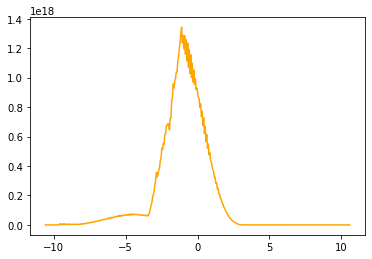

In [48]:
plt.plot(z_nm, (hbar_to_eV_fs / au_to_m)*oam_integrated[2], color="orange")

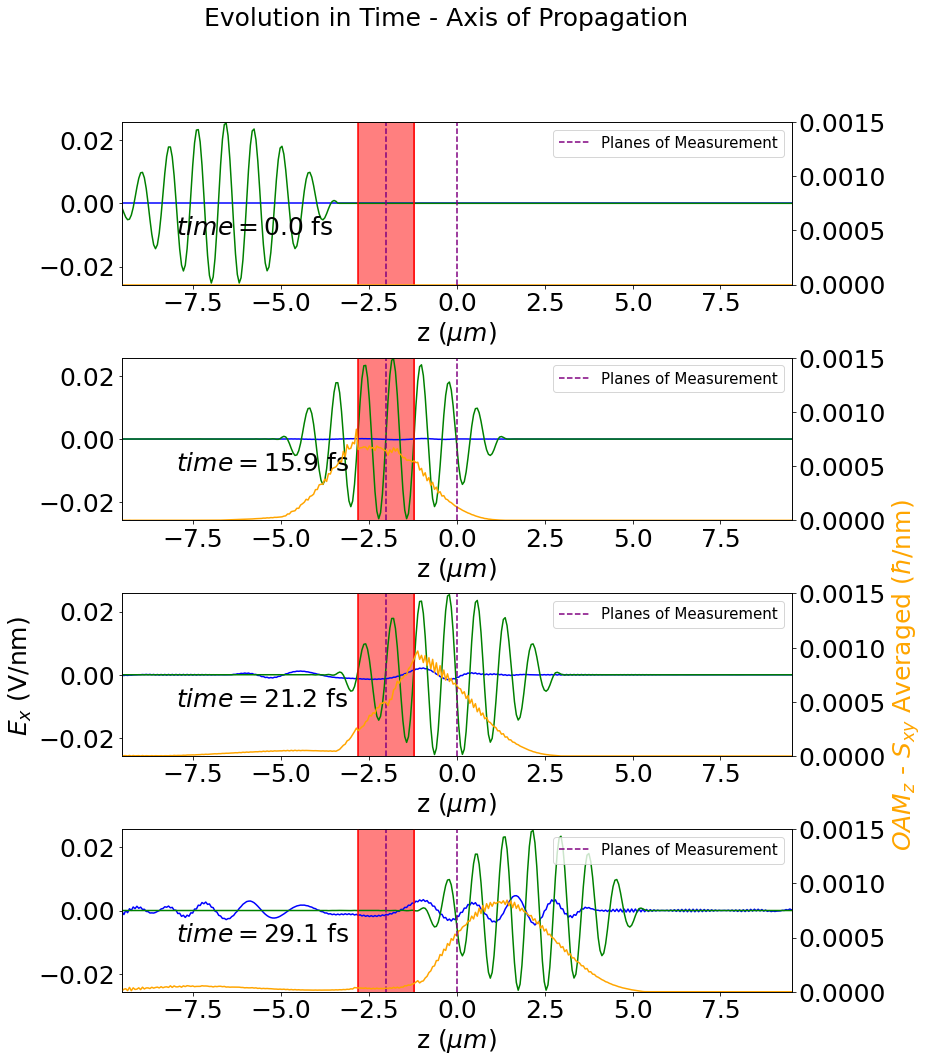

In [7]:
from matplotlib.gridspec import GridSpec
fontsize = 12
coef = 4054.0
z_nm = npoints*au_to_micm
aut_to_fs =  0.02418884327       #atomic unit times to femtoseconds
#au_to_largeunits = 0.16 #microns
#au_to_microns = 1/0.0529*1e3
offset = -12516.9279803-10*coef    #in au, far offset is this, mid one is -1.5*coef
thickness =  1.6   #1600 nm =1.6 micm
x_spiral = [(offset)*au_to_micm,offset*au_to_micm + thickness]
#OAM_largeunits = au_to_largeunits*au_to_microns*OAM_int_axistimetot
y1lim = 5e-5*au_to_voltpernm
#y2lim = 3.3e-2*au_to_largeunits*au_to_microns
y2lim = 0.0015  #au_to_voltpernm = 5.14220826e2  #1 au = 5.14220652E+11 V/m  #1.2e14   #200000*au_to_nm/coef
zlim=z_nm.max()*0.9
# Set up figure
plot_count = 4 ##len(timeiters) # number of plot counts in the frame, can be changed
cross_sectp = 2e5*2e5*(au_to_nm**2)  #cross section in nm
# Build subplots
if not os.path.isdir('frames_integratedoam'): os.mkdir('frames_integratedoam')
#for iframes in np.arange(plot_count%5):
for iframes in np.arange(0,len(timeiters)/plot_count):
    fig = plt.figure(figsize=(12,16))
    fig.suptitle("Evolution in Time - Axis of Propagation", fontsize=25) 
    #fig.suptitle("Electric Field$_{x}$  (V/nm) Cross Profile", fontsize=25) 
    gs = GridSpec(plot_count, 1, hspace=0.45)
    for ii in np.arange(plot_count):
        ax1 = fig.add_subplot(gs[ii, 0])  # for e_field
        ax2 = ax1.twinx()
        for xc in x_spiral:
            plt.axvline(x=xc,color='r')
        iplots = int(ii+ iframes*plot_count)
        if iplots > len(timeiters)-1 : break;
        ax1.plot(z_nm, efield_x[iplots], 'b-',label = 'Induced')
        ax1.plot(z_nm, efield_x_source[iplots], 'g-', label='External')
        ax1.set_ylim(-y1lim,y1lim)
        #measurement_pos = -3500  #planes_list[iplane]
        #ax1.annotate('Plane of Measurement', 
        #     xy=(measurement_pos,-4.5e-5), 
        #     xytext=(measurement_pos,-4.9e-5), 
        #     arrowprops = dict(arrowstyle='->', color='blue', linewidth=1, mutation_scale=50))
        #ax2.plot(z_nm, 1/c_light**2 * (hbar_to_eV_fs / au_to_m)*oam_integrated[iplots], color="orange")
        #plt.plot(z_nm, 1/c_light**2 *(1/au_to_nm) *oam_integrated[2]/cross_sectp)
        ax2.plot(z_nm, 1/c_light**2 *(1/au_to_nm) * oam_integrated[iplots]/cross_sectp, color="orange")
        ax2.set_ylim(0.0,y2lim)
        ax2.yaxis.set_major_locator(plt.MaxNLocator(3))
        ax2.tick_params(axis='both', which='major', labelsize=25)
        ax1.text(-8.0,-1e-2,'$time = {:.1f}$ fs'.format(timeiters[iplots]*timestep*aut_to_fs), fontsize=25)
        ax1.set_xlim(-zlim,zlim)
        ax1.axvspan(x_spiral[0], x_spiral[1], color='red', alpha=0.5)
        ax1.set_xlabel('z ($\mu m$)', fontsize=25)
        ax1.axvline(x=-2.018735462, linestyle='dashed',c='purple')
        ax1.tick_params(axis='both', which='major', labelsize=25)
        ax2.axvline(x=0.0, linestyle='dashed',c='purple', label='Planes of Measurement') #x=-3500
        ax2.legend(fontsize =15) 
        if iplots%plot_count == 2:
            ax1.set_ylabel('$E_x$ (V/nm) ', color='black', fontsize=25)
            #ax2.legend()
            ax2.set_ylabel('$OAM_{z}$ - $S_{xy}$ Averaged ($\hbar$/nm)', color='orange', fontsize=25)
#         if iplots%plot_count == 3:
#             ax2.axvline(x=0.0, linestyle='dashed')
    plt.savefig('frames_integratedoam/integrated_oam_over_propaxis_frame'+ str(iframes)+'mataxis.png', dpi=400, bbox_inches='tight')


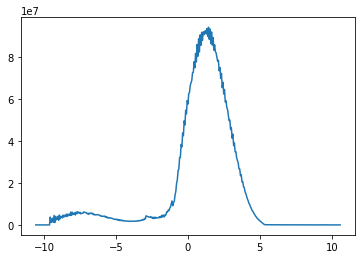

In [64]:
plt.plot(z_nm, oam_integrated[3])

In [61]:
dx = ys[1]-ys[0]
full_integrate_box = integrate.simps(1/c_light**2 * oam_integrated[2],dx = dx, axis =-1)
    #z_nm, 1/c_light**2 * oam_integrated[iplots], color="orange")

Text(0.5, 1.0, 'xy-averaged OAM density in hbar / nm / nm$^2$ = hbar / nm$^3$')

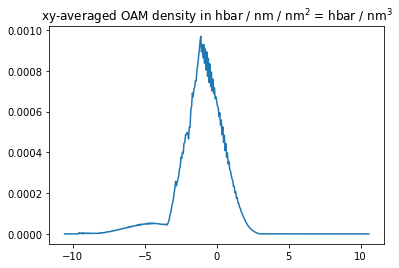

In [78]:
plt.plot(z_nm, 1/c_light**2 *(1/au_to_nm) *oam_integrated[2]/cross_sectp)
plt.title('xy-averaged OAM density in hbar / nm / nm$^2$ = hbar / nm$^3$')

$\bar{L}(z) = \frac{1}{Cross-section Area} \int\int dx dy L(x,y,z)$

$L(x,y,z) = \frac{1}{c^{2}} \vec{r} \times (\frac{1}{\mu_{0}}) \vec{E}\times\vec{B} = \epsilon_{0} \vec{r} \times \vec{E}\times\vec{B}$

In [73]:
full_integrate_box
cross_sectp = 2e5*2e5*(au_to_nm**2)
full_integrate_box/cross_sectp

2.740168390566995

In [70]:
! cat "Maxwell/output_iter/td.0008000/orbital_angular_momentum-z.z=0"

#         x                      y                     Re                     Im





 -3.00000000000000E+005 -3.00000000000000E+005  0.00000000000000E+000
 -3.00000000000000E+005 -2.99000000000000E+005  0.00000000000000E+000
 -3.00000000000000E+005 -2.98000000000000E+005  0.00000000000000E+000
 -3.00000000000000E+005 -2.97000000000000E+005  0.00000000000000E+000
 -3.00000000000000E+005 -2.96000000000000E+005  0.00000000000000E+000
 -3.00000000000000E+005 -2.95000000000000E+005  0.00000000000000E+000
 -3.00000000000000E+005 -2.94000000000000E+005  0.00000000000000E+000
 -3.00000000000000E+005 -2.93000000000000E+005  0.00000000000000E+000
 -3.00000000000000E+005 -2.92000000000000E+005  0.00000000000000E+000
 -3.00000000000000E+005 -2.91000000000000E+005  0.00000000000000E+000
 -3.00000000000000E+005 -2.90000000000000E+005  0.00000000000000E+000
 -3.00000000000000E+005 -2.89000000000000E+005  0.00000000000000E+000
 -3.00000000000000E+005 -2.88000000000000E+005  0.00000000000000E+000
 -3.

 -2.96000000000000E+005 -1.22000000000000E+005  0.00000000000000E+000
 -2.96000000000000E+005 -1.21000000000000E+005  0.00000000000000E+000
 -2.96000000000000E+005 -1.20000000000000E+005  0.00000000000000E+000
 -2.96000000000000E+005 -1.19000000000000E+005  0.00000000000000E+000
 -2.96000000000000E+005 -1.18000000000000E+005  0.00000000000000E+000
 -2.96000000000000E+005 -1.17000000000000E+005  0.00000000000000E+000
 -2.96000000000000E+005 -1.16000000000000E+005  0.00000000000000E+000
 -2.96000000000000E+005 -1.15000000000000E+005  0.00000000000000E+000
 -2.96000000000000E+005 -1.14000000000000E+005  0.00000000000000E+000
 -2.96000000000000E+005 -1.13000000000000E+005  0.00000000000000E+000
 -2.96000000000000E+005 -1.12000000000000E+005  0.00000000000000E+000
 -2.96000000000000E+005 -1.11000000000000E+005  0.00000000000000E+000
 -2.96000000000000E+005 -1.10000000000000E+005  0.00000000000000E+000
 -2.96000000000000E+005 -1.09000000000000E+005  0.00000000000000E+000
 -2.96000000000000E+

 -2.84000000000000E+005  2.90000000000000E+005 -0.00000000000000E+000
 -2.84000000000000E+005  2.91000000000000E+005 -0.00000000000000E+000
 -2.84000000000000E+005  2.92000000000000E+005 -0.00000000000000E+000
 -2.84000000000000E+005  2.93000000000000E+005 -0.00000000000000E+000
 -2.84000000000000E+005  2.94000000000000E+005 -0.00000000000000E+000
 -2.84000000000000E+005  2.95000000000000E+005 -0.00000000000000E+000
 -2.84000000000000E+005  2.96000000000000E+005 -0.00000000000000E+000
 -2.84000000000000E+005  2.97000000000000E+005 -0.00000000000000E+000
 -2.84000000000000E+005  2.98000000000000E+005 -0.00000000000000E+000
 -2.84000000000000E+005  2.99000000000000E+005 -0.00000000000000E+000
 -2.84000000000000E+005  3.00000000000000E+005 -0.00000000000000E+000

 -2.83000000000000E+005 -3.00000000000000E+005  0.00000000000000E+000
 -2.83000000000000E+005 -2.99000000000000E+005  0.00000000000000E+000
 -2.83000000000000E+005 -2.98000000000000E+005  0.00000000000000E+000
 -2.83000000000000E

 -2.70000000000000E+005 -2.23000000000000E+005 -6.62413657927277E-006
 -2.70000000000000E+005 -2.22000000000000E+005  1.73503065880438E-006
 -2.70000000000000E+005 -2.21000000000000E+005 -8.41006139670870E-006
 -2.70000000000000E+005 -2.20000000000000E+005  1.33038674961803E-006
 -2.70000000000000E+005 -2.19000000000000E+005 -9.68814986796918E-006
 -2.70000000000000E+005 -2.18000000000000E+005  1.84919358960890E-006
 -2.70000000000000E+005 -2.17000000000000E+005 -1.03375125939028E-005
 -2.70000000000000E+005 -2.16000000000000E+005  3.10573464793988E-006
 -2.70000000000000E+005 -2.15000000000000E+005 -1.01869048798738E-005
 -2.70000000000000E+005 -2.14000000000000E+005  4.57381263995308E-006
 -2.70000000000000E+005 -2.13000000000000E+005 -9.29143527626925E-006
 -2.70000000000000E+005 -2.12000000000000E+005  5.96856577591515E-006
 -2.70000000000000E+005 -2.11000000000000E+005 -7.93893606616385E-006
 -2.70000000000000E+005 -2.10000000000000E+005  6.91633338677574E-006
 -2.70000000000000E+

 -2.57000000000000E+005  1.90000000000000E+005  1.75151383017580E-006
 -2.57000000000000E+005  1.91000000000000E+005 -3.95878494645354E-006
 -2.57000000000000E+005  1.92000000000000E+005  4.16616844989110E-007
 -2.57000000000000E+005  1.93000000000000E+005 -3.76573507498638E-006
 -2.57000000000000E+005  1.94000000000000E+005 -1.10820105021348E-006
 -2.57000000000000E+005  1.95000000000000E+005 -4.07884589353842E-006
 -2.57000000000000E+005  1.96000000000000E+005 -2.59073223974567E-006
 -2.57000000000000E+005  1.97000000000000E+005 -4.74398861071371E-006
 -2.57000000000000E+005  1.98000000000000E+005 -3.64060270493208E-006
 -2.57000000000000E+005  1.99000000000000E+005 -5.25518983214108E-006
 -2.57000000000000E+005  2.00000000000000E+005 -3.61585606604941E-006
 -2.57000000000000E+005  2.01000000000000E+005 -5.08465652352907E-006
 -2.57000000000000E+005  2.02000000000000E+005 -2.22787583937633E-006
 -2.57000000000000E+005  2.03000000000000E+005 -4.18654046171324E-006
 -2.57000000000000E+

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(0, 300)

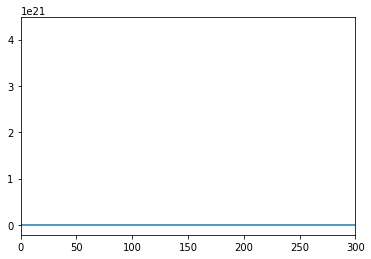

In [70]:
plt.plot(oam_integrated[2,:]/oam_integrated_norm[:])
plt.xlim([0,300])

In [43]:
oam_integrated_norm.shape

(401,)

In [82]:
x_spiral

[-2807.651918900628, -1207.651918900628]

In [84]:
x_mid = (x_spiral[0] +  x_spiral[1])/2
x_mid

-2007.651918900628